# 2024-01-26 DEV: dataset alignment and validation


**Goal**: develop a class of methods to load in old and new datasets for an animal and produce figures to ensure alignment and explain any variation in model results that may occur. 

See the explore_W078 version of this notebook for the initial analyses related timeout (non-engage) trials and violations

## Load in (note first NB with package use!)

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from multiglm.data.get_rat_data import *

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


class DatasetLoadAndAlign:
    """
    Class for loading and aligning the old and new datasets
    for a given animal across sessions. Additionally, this
    class adds and computes some columns that will be
    useful for visualizations.

    note: this class is not meant to be used directly, but
    rather to be inherited by a class that will perform
    the visualization so everything happens in init
    """

    def __init__(
        self,
        animal_id,
        new_data_path="/Volumes/brody/jbreda/PWM_data_scrape/",
        alignment_df_base_path="../data/processed/dataset_alignment/",
    ):
        print(f"** RUNNING {animal_id} **")
        self.animal_id = animal_id
        self.new_data_path = new_data_path
        self.alignment_df_path = Path(
            alignment_df_base_path + f"{self.animal_id}_alignment_df.csv"
        )
        self.old_df = self.get_old_df(animal_id)
        self.old_df_viol_only = self.get_old_df_viol_only(animal_id)
        self.new_df = self.get_new_df(animal_id)
        self.new_df_no_touts = self.get_new_df_no_touts(animal_id)
        self.combined_df = self.combine_data()
        self.save_combined_data_stats()

    def get_old_df(self, animal_id):
        """
        using data.get_rat_data, get the full rat data for the animal_id
        this is the PUBLICLY AVAILABLE data that was published with
        Athena's paper
        """
        self.old_df = get_full_rat_data(animal_id, mode="local")
        self.old_df["source"] = "old"
        return self.old_df

    def get_old_df_viol_only(self, animal_id):
        """
        using data.get_rat_viol_data, get data from the "full" dataset when
        violations are tracked. this animal specific threshold was determined in the
        notebooks/create_violation_dataset.ipynb notebook and is best approximated
        by session 200
        """

        # load
        old_df_viol_only = get_rat_viol_data(animal_id, mode="local")

        # format
        old_df_viol_only["source"] = "old_only_viols"
        self.old_df_viol_only = old_df_viol_only

        return self.old_df_viol_only

    def get_new_df(self, animal_id):
        """
        Function to load the "new" data that was scraped form .mat
        data files in matlab. This data has extra columns as well as
        differing column names from the old data so some alignment
        and validation needs to be performed.
        """
        # load
        f_name = f"{animal_id}_trials_data.csv"
        new_df = pd.read_csv(self.new_data_path + f_name)

        # format
        new_df["source"] = "new"
        new_df["violation"] = new_df["violation_history"]  # lazy copy for renaming
        new_df["animal_id"] = new_df["rat_name"]
        new_df = self.add_trials_column(new_df)
        new_df = self.align_new_to_old(new_df)
        new_df = self.create_viol_and_tout_column(new_df)
        self.new_df = new_df
        print(f"returning new data for {animal_id}")

        return self.new_df

    def get_new_df_no_touts(self, animal_id):
        """
        Based on the initial analysis in 2024_01_24_
        explore_w078_dataset_remake.ipynb, it appears that timeout
        trials were marked as violations in the public dataset. Thus,
        this function returns a new dataset with timeout trials for
        comparative metrics.
        """
        # load
        if not hasattr(self, "new_df"):
            self.new_df = self.get_new_df(animal_id)

        # filter
        new_df_no_touts = self.new_df.query("timeout_history != 1").reset_index(
            drop=True
        )

        # format (overwrite source and trials column)
        new_df_no_touts["source"] = "new_no_touts"
        new_df_no_touts = self.add_trials_column(new_df_no_touts)
        self.new_df_no_touts = new_df_no_touts

        assert (
            self.new_df_no_touts.trial.max() != self.new_df.trial.max()
        ), "error: new data with no touts has same trial max as new data"

        print(f"returning new data with no touts for {animal_id}")

        return self.new_df_no_touts

    @staticmethod
    def add_trials_column(df, groupby_col="session_counter"):
        """
        Breif method for adding a trial count column that
        resets for each session to the "new" dfs since
        they were not made in matlab
        """

        def _add_trial_column(group):
            group["trial"] = np.arange(1, len(group) + 1)
            return group

        df = df.copy()
        df = df.groupby(groupby_col).apply(_add_trial_column).reset_index(drop=True)

        return df

    @staticmethod
    def create_viol_and_tout_column(df):
        """
        Brief method for adding a column is a 1 if the the trial
        was a violation or if the trial was a time out. Based on
        initial analyses, it appears that timeout trials were
        marked as violations in the public dataset, so this
        column should approximate the "violations" column in
        the public dataset
        """

        df = df.copy()
        df["timeout_and_violation_history"] = df.violation_history + df.timeout_history

        assert (
            df.timeout_and_violation_history.max() == 1
        ), "error: trial marked as both timeout and violation!"

        return df

    def align_new_to_old(self, new_df):
        """
        The old (public) and new datasets don't have the same exact
        sessions. This function finds a session alignment by finding the
        session with max trials in common between the two datasets within
        the first 50 sessions and creates a new column in the new dataset
        for the aligned session number.
        """

        # find trial max for old and new & corresponding session
        new_df_aligned = new_df.copy()

        new_df_tmax = new_df.query("session_counter < 50").trial.max()
        new_session = new_df.query(
            "session_counter < 50 and trial == @new_df_tmax"
        ).session_counter.max()

        if not hasattr(self, "old_df"):
            self.old_df = self.get_old_df(self.animal_id)

        old_df_tmax = self.old_df.query("session < 50").trial.max()
        old_session = self.old_df.query(
            "session < 50 and trial == @old_df_tmax"
        ).session.max()

        # compute delta between sessions and use to align
        delta_for_align_new_to_old = old_session - new_session
        new_df_aligned["session"] = (
            new_df_aligned.session_counter + delta_for_align_new_to_old
        )

        # save out for later
        data = {
            "animal_id": [self.animal_id, self.animal_id],
            "source": ["new", "old"],
            "max_trial": [new_df_tmax, old_df_tmax],
            "align_session": [new_session, old_session],
        }

        self.save_alignment_data(data)

        return new_df_aligned

    def save_alignment_data(self, data):
        """
        save out alignment data to csv so that you can
        locate the session alignment for each animal
        """
        # see if exits using PATH library
        if Path.exists(self.alignment_df_path):
            alignment_df = pd.read_csv(self.alignment_df_path)

            if self.animal_id in alignment_df.animal_id.values:
                print(f"alignment data already exists for {self.animal_id}")
                return

            new_data_df = pd.DataFrame(data=data)

            alignment_df = pd.concat([alignment_df, new_data_df]).reset_index(drop=True)

            alignment_df.to_csv(self.alignment_df_path, index=False)

            print(
                f"    new to old alignment appended to existing df for {self.animal_id}"
            )
        else:
            alignment_df = pd.DataFrame(data=data)

            alignment_df.to_csv(self.alignment_df_path, index=False)

            print(f"new to old alignment df created containing {self.animal_id}")

    def combine_data(self):
        """
        function to concat all four data frames on shared columns to be used
        for plotting
        """
        shared_cols = ["session", "trial", "source", "training_stage", "violation"]

        self.combined_df = pd.concat(
            [
                self.old_df[shared_cols],
                self.old_df_viol_only[shared_cols],
                self.new_df[shared_cols],
                self.new_df_no_touts[shared_cols],
            ],
            axis=0,
        ).reset_index(drop=True)

        return self.combined_df

    def save_combined_data_stats(self):
        aligned_df = pd.read_csv(self.alignment_df_path)

        if "n_sessions" in aligned_df.columns:
            print(
                f"alignment summary data across dfs already computed for {self.animal_id}"
            )
            return

        # Session Data- Number of Unique Sessions
        sessions = self.combined_df.groupby(["source"]).session.nunique().reset_index()
        sessions["animal_id"] = self.animal_id
        sessions.rename(columns={"session": "n_sessions"}, inplace=True)
        merged_df = pd.merge(
            aligned_df, sessions, on=["animal_id", "source"], how="outer"
        )

        # Trials Data- Avg Trials Per Session
        trials = (
            self.combined_df.groupby(["source", "session"])
            .trial.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        trials.rename(columns={"trial": "n_trials_per_session"}, inplace=True)
        trials["animal_id"] = self.animal_id
        merged_df = pd.merge(merged_df, trials, on=["animal_id", "source"], how="outer")

        # Violations Data- Avg Violation Rate Per Session
        violations = (
            self.combined_df.query("session < 200")
            .groupby(["source", "session"])
            .violation.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        violations.rename(columns={"violation": "session_avg_violation"}, inplace=True)
        violations["animal_id"] = self.animal_id
        merged_df = pd.merge(
            merged_df, violations, on=["animal_id", "source"], how="outer"
        )

        # Violations Stage 4 Data
        violations_stage_4 = (
            self.combined_df.query("session < 200 and training_stage == 4")
            .groupby(["source", "session"])
            .violation.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        violations_stage_4.rename(
            columns={"violation": "session_avg_violation_stage_4"}, inplace=True
        )
        violations_stage_4["animal_id"] = self.animal_id
        merged_df = pd.merge(
            merged_df, violations_stage_4, on=["animal_id", "source"], how="outer"
        )

        # Save out
        merged_df.to_csv(self.alignment_df_path, index=False)
        print(f"saved alignment summary data across dfs for {self.animal_id}")
        self.merged_df = merged_df

    # maybe: compute violation iti df

In [ ]:
w078 = DatasetLoadAndAlign("W078", new_data_path="../data/raw/")

In [ ]:
class ViolationITI:
    def __init__(self):
        pass

    def compute_and_add_viol_iti_column(self, df):
        self.run_checks(df)

        df["violation_iti"] = np.nan
        df_with_iti = (
            df.groupby(["animal_id", "session"])
            .apply(self.calculate_violation_intervals)
            .reset_index(drop=True)
        )

        return df_with_iti

    def plot_data_over_trials(self, df, start_idx=None, end_idx=None):
        if start_idx:
            plot_data = df.iloc[start_idx:end_idx]
        else:
            plot_data = df.copy()

        n_sessions = plot_data.session.nunique()

        fig, ax = plt.subplots(
            n_sessions, 1, figsize=(10, (n_sessions * 3)), constrained_layout=True
        )

        for i, (session, group) in enumerate(plot_data.groupby("session")):
            cur_ax = ax[i] if n_sessions > 1 else ax
            cur_ax.plot(
                group.trial,
                group.violation,
                "o",
                label="Viol Hist",
            )
            cur_ax.plot(
                group.trial,
                group.violation_iti,
                "x",
                color="red",
                label="Viol ITI",
            )

            cur_ax.set(
                xlabel="Trial",
                ylabel="was viol / viol ITI",
                title=f"Session: {session}",
            )
        cur_ax.legend()

    @staticmethod
    def simulate_data(n_sessions=3, n_trials=25, random_state=None):
        data = []

        for session in range(1, n_sessions + 1):
            for trial in range(1, n_trials + 1):
                # Randomly decide if a violation occurred (for simplicity, say 20% chance)
                np.random.seed(random_state)
                violation = np.random.choice(
                    [0, 1],
                    p=[0.8, 0.2],
                )
                data.append(["example_animal", session, trial, violation])

        # Create DataFrame
        columns = ["animal_id", "session", "trial", "violation"]
        simulated_df = pd.DataFrame(data, columns=columns)

        return simulated_df

    @staticmethod
    def run_checks(df):
        required_columns = ["animal_id", "trial", "session", "violation"]
        assert all(
            column in df.columns for column in required_columns
        ), "Required columns not present!"

    @staticmethod
    def calculate_violation_intervals(group):
        """
        function to be used with a pandas "apply" when
        grouping by session (can also group by animal_id
        if running multiple animals at a time)
        """

        # Get trial numbers of trials with a violation
        violation_trials = group["trial"][group["violation"] == 1]

        # Calculate number of trials between trials with a violation
        # shift by 1 to align trials properly
        intervals = violation_trials.diff() - 1

        # Assign the calculated intervals back to the group,
        # All violation trials (except the first of a group) get a value,
        # every other trial type gets an nan
        group.loc[violation_trials.index, "violation_iti"] = intervals

        return group

In [ ]:
iti = ViolationITI()

pp = iti.compute_and_add_viol_iti_column(w078.new_df_no_touts)

ss = iti.compute_and_add_viol_iti_column(iti.simulate_data())

In [ ]:
old_df_w_iti = iti.compute_and_add_viol_iti_column(w078.old_df_viol_only)
new_df_w_iti = iti.compute_and_add_viol_iti_column(w078.new_df_no_touts)

shared_cols = ["source", "session", "training_stage", "violation_iti"]

viol_iti_combined = pd.concat(
    [old_df_w_iti[shared_cols], new_df_w_iti[shared_cols]],
).reset_index(drop=True)

In [ ]:
sns.histplot(
    data=viol_iti_combined.query("training_stage == 4 and session < 200"),
    x="violation_iti",
    hue="source",
    hue_order=["new_no_touts", "old_only_viols"],
    binwidth=1,
    element="step",
)

plt.xlim(0, 20)
plt.title("W078 Stage 4 Violation ITI Distribution")

In [ ]:
sns.histplot(
    data=viol_iti_combined.query("training_stage == 4 and session < 200"),
    x="violation_iti",
    hue="source",
    hue_order=["new", "old"],
    binwidth=1,
    element="step",
)

plt.xlim(0, 20)
plt.title("W078 Stage 4 Violation ITI Distribution")

In [ ]:
iti.plot_data_over_trials(ss)

In [ ]:
s = 4500
e = 4520

fig, ax = plt.subplots(figsize=(12, 4))
session = 2
plt.plot(
    pp.iloc[s:e].trial,
    pp.iloc[s:e].violation,
    "o",
    label="violation history",
)

# ax2 = ax.twinx()
plt.plot(
    pp.iloc[s:e].trial,
    pp.iloc[s:e].violation_iti,
    "x",
    color="red",
    label="violation iti",
)

In [547]:
class DatasetVisualizer:
    def __init__(self, aligned_data):
        self.animal_id = aligned_data.animal_id
        self.combined_data = aligned_data.combined_df
        self.aligned_data = aligned_data

    def plot_trial_counts(self, with_touts, ax=None):
        """
        create a plot for trial counts of old and new data
        either with or without violations
        """

        if ax is None:
            ax = self.make_fig()

        new_data, title_str = self.determine_which_new_df(with_touts)

        # plot
        sns.lineplot(
            data=new_data,
            x="session",
            y="trial",
            estimator="max",
            ax=ax,
            errorbar=None,
            label="New",
        )

        sns.lineplot(
            data=self.aligned_data.old_df,
            x="session",
            y="trial",
            estimator="max",
            ax=ax,
            errorbar=None,
            label="Old",
            ls="--",
        )

        ax.legend()
        _ = ax.set(
            title=f"{self.animal_id} Trial Counts {title_str}",
            xlabel="Session",
            ylabel="Trial",
        )

        return None

    def plot_hit_rates(self, with_touts=False, ax=None):
        if ax is None:
            ax = self.make_fig()

        new_data, title_str = self.determine_which_new_df(with_touts)

        # plot
        sns.lineplot(
            data=new_data,
            x="session",
            y="hit_history",
            estimator="mean",
            ax=ax,
            errorbar=None,
            label="New",
        )

        sns.lineplot(
            data=self.aligned_data.old_df,
            x="session",
            y="hit",
            estimator="mean",
            ax=ax,
            errorbar=None,
            label="Old",
            ls="--",
        )

        ax.legend()
        _ = ax.set(
            title=f"{self.animal_id} Hit Rates {title_str}",
            xlabel="Session",
            ylabel="Hit Rate",
        )

        return None

    def plot_violation_rates(self, with_touts=False, ax=None):
        if ax is None:
            ax = self.make_fig()

        new_data, title_str = self.determine_which_new_df(with_touts)

        if with_touts:
            yvar = "timeout_and_violation_history"
            ylab = "Timeouts + Violations"
        else:
            yvar = "violation_history"
            ylab = "Violations"

        # plot
        sns.lineplot(
            data=new_data,
            x="session",
            y=yvar,
            estimator="mean",
            ax=ax,
            errorbar=None,
            label="New",
        )

        sns.lineplot(
            data=self.aligned_data.old_df,
            x="session",
            y="violation",
            ax=ax,
            errorbar=None,
            label="Old",
            ls="--",
        )

        ax.legend()
        _ = ax.set(
            title=f"{self.animal_id} Violation Rate {title_str}",
            xlabel="Session",
            ylabel=ylab,
        )

        return None

    def plot_timeout_rates(self, ax=None):
        if ax is None:
            ax = self.make_fig()

        sns.lineplot(
            data=self.aligned_data.new_df,
            x="session",
            y="timeout_history",
            estimator="mean",
            hue="training_stage",
            palette="tab10",
            ax=ax,
            errorbar=None,
        )

        session_mean = (
            self.aligned_data.new_df.groupby("session").timeout_history.mean().mean()
        )
        ax.axhline(session_mean, color="k", ls="--")

        ax.legend(title="Training Stage")
        ax.set(
            title=f"{self.animal_id} Timeout Rate \n Session Mean: {session_mean:.2f}",
            xlabel="Session",
            ylabel="Timeout Rate",
        )

        return None

    def plot_n_sessions(self, ax=None):
        if ax is None:
            ax = self.make_fig((7, 5))

        # compute df for plot
        unique_sessions = (
            self.combined_data.groupby("source").session.nunique().reset_index()
        )

        # plot
        sns.pointplot(
            x="source",
            y="session",
            data=unique_sessions.query("source != 'old_only_viols'"),
            color="black",
            ax=ax,
        )

        # aesthetics
        session_diff = (
            unique_sessions.query("source == 'new_no_touts'").session.values[0]
            - unique_sessions.query("source == 'old'").session.values[0]
        )

        _ = ax.set(
            title=f"New DF Difference: {session_diff}",
            xlabel="",
            ylabel="Session Count",
        )

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        return None

    def plot_n_trials_per_session(self, ax=None, **kwargs):
        if ax is None:
            ax = self.make_fig((7, 5))

        # compute df for plot
        trials_per_session = (
            self.combined_data.groupby(["source", "session", "training_stage"])
            .trial.max()
            .reset_index()
        )

        # plot
        sns.pointplot(
            x="source",
            y="trial",
            data=trials_per_session.query("source != 'old_only_viols'"),
            ax=ax,
            color="black",
            **kwargs,
        )

        # aesthetics
        trial_diff = (
            trials_per_session.query("source == 'new_no_touts'").trial.mean()
            - trials_per_session.query("source == 'old'").trial.mean()
        )

        _ = ax.set(
            title=f"New DF Difference: {trial_diff:.2f}",
            xlabel="",
            ylabel="Trials/Session",
        )

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        return None

    def plot_viol_rate_per_session_all_stages(self, ax=None, **kwargs):
        if ax is None:
            ax = self.make_fig((7, 5))

        # compute df for plot
        viols_per_session = (
            self.combined_data.groupby(["source", "training_stage", "session"])
            .violation.mean()
            .reset_index()
        )

        viols_per_session = viols_per_session.query("session < 200").copy()

        # plot
        sns.pointplot(
            x="source",
            y="violation",
            data=viols_per_session.query("source != 'old'"),
            ax=ax,
            color="black",
            **kwargs,
        )

        # aesthetics
        viol_diff = (
            viols_per_session.query("source == 'new_no_touts'").violation.mean()
            - viols_per_session.query("source =='old_only_viols'").violation.mean()
        )

        _ = ax.set(
            xlabel="",
            ylabel="Session Avg Violation Rate",
            title=f"Sess Avg Violation Rate All Stages \n New No Tout DF Difference: {viol_diff:.2f}",
            ylim=(
                self.determine_viol_plot_ylims(
                    viols_per_session.query("source != 'old'")
                )
            ),
        )

        for item in ax.get_xticklabels():
            item.set_rotation(25)

        return None

    def plot_viol_rate_per_session_stage_4(self, ax=None):
        if ax is None:
            ax = self.make_fig((7, 5))

        # compute df for plot
        viols_per_session = (
            self.combined_data.groupby(["source", "training_stage", "session"])
            .violation.mean()
            .reset_index()
        )

        ymin, ymax = self.determine_viol_plot_ylims(
            viols_per_session.query("session < 200 and source != 'old'")
        )

        viols_per_session = viols_per_session.query(
            "session < 200 and training_stage == 4 and source != 'old'"
        ).copy()

        # plot
        sns.pointplot(
            x="source",
            y="violation",
            data=viols_per_session,
            ax=ax,
            color="red",
        )

        # aesthetics
        viol_diff = (
            viols_per_session.query("source == 'new_no_touts'").violation.mean()
            - viols_per_session.query("source =='old_only_viols'").violation.mean()
        )

        _ = ax.set(
            xlabel="",
            ylabel="Session Avg Violation Rate",
            title=f"Sess Avg Violation Rate Stage 4 \n New No Tout DF Difference: {viol_diff:.2f}",
            ylim=(ymin, ymax),
        )

        for item in ax.get_xticklabels():
            item.set_rotation(25)

        return None

    def plot_violation_iti(self, ax=None, xmax=20):
        if ax is None:
            ax = self.make_fig((7, 5))

        viol_iti_df = self.compute_iti_df()

        sns.histplot(
            data=viol_iti_df.query("training_stage == 4 and session < 200"),
            x="violation_iti",
            hue="source",
            hue_order=["new_no_touts", "old_only_viols"],
            binwidth=1,
            element="step",
            ax=ax,
        )

        ax.set(xlim=(0, xmax), title="Stage 4 Violation ITI Distribution")

        return None

    ## HELPERS ##
    def determine_which_new_df(self, with_touts):
        if with_touts:
            new_data = self.aligned_data.new_df
            title_str = "With Time Outs"
        else:
            new_data = self.aligned_data.new_df_no_touts
            title_str = "Without Time Outs"

        return new_data, title_str

    @staticmethod
    def make_fig(dims=(12, 4)):
        _, ax = plt.subplots(figsize=dims)
        return ax

    def determine_viol_plot_ylims(self, data):
        """
        helper function to determine ylims for violation plots so that
        the plot across all stages can have the same ylim at the plot
        that only is stage 4
        """

        viol_ymin, viol_ymax = data.violation.quantile([0.05, 0.95])

        return viol_ymin, viol_ymax

    def compute_iti_df(self):
        """
        wrapper method to use the ViolationITI class for
        computing violation iti column for old and new df
        of interest and them combine them into a single df
        """

        # initiate & compute
        iti = ViolationITI()

        old_df_w_iti = iti.compute_and_add_viol_iti_column(
            self.aligned_data.old_df_viol_only
        )
        new_df_w_iti = iti.compute_and_add_viol_iti_column(
            self.aligned_data.new_df_no_touts
        )

        # combine
        shared_cols = ["source", "session", "training_stage", "violation_iti"]

        viol_iti_combined = pd.concat(
            [old_df_w_iti[shared_cols], new_df_w_iti[shared_cols]],
        ).reset_index(drop=True)

        return viol_iti_combined

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


class DatasetLoadAndAlign:
    """
    Class for loading and aligning the old and new datasets
    for a given animal across sessions. Additionally, this
    class adds and computes some columns that will be
    useful for visualizations.

    note: this class is not meant to be used directly, but
    rather to be inherited by a class that will perform
    the visualization so everything happens in init
    """

    def __init__(
        self,
        animal_id,
        new_data_path="/Volumes/brody/jbreda/PWM_data_scrape/",
        alignment_df_base_path="../data/processed/dataset_alignment/",
    ):
        print(f"** RUNNING {animal_id} **")
        self.animal_id = animal_id
        self.new_data_path = new_data_path
        self.alignment_df_path = Path(
            alignment_df_base_path + f"{self.animal_id}_alignment_df.csv"
        )
        self.old_df = self.get_old_df(animal_id)
        self.old_df_viol_only = self.get_old_df_viol_only(animal_id)
        self.new_df = self.get_new_df(animal_id)
        self.new_df_no_touts = self.get_new_df_no_touts(animal_id)
        self.combined_df = self.combine_data()
        self.save_combined_data_stats()

    def get_old_df(self, animal_id):
        """
        using data.get_rat_data, get the full rat data for the animal_id
        this is the PUBLICLY AVAILABLE data that was published with
        Athena's paper
        """
        self.old_df = get_full_rat_data(animal_id, mode="local")
        self.old_df["source"] = "old"
        return self.old_df

    def get_old_df_viol_only(self, animal_id):
        """
        using data.get_rat_viol_data, get data from the "full" dataset when
        violations are tracked. this animal specific threshold was determined in the
        notebooks/create_violation_dataset.ipynb notebook and is best approximated
        by session 200
        """

        # load
        old_df_viol_only = get_rat_viol_data(animal_id, mode="local")

        # format
        old_df_viol_only["source"] = "old_only_viols"
        self.old_df_viol_only = old_df_viol_only

        return self.old_df_viol_only

    def get_new_df(self, animal_id):
        """
        Function to load the "new" data that was scraped form .mat
        data files in matlab. This data has extra columns as well as
        differing column names from the old data so some alignment
        and validation needs to be performed.
        """
        # load
        f_name = f"{animal_id}_trials_data.csv"
        new_df = pd.read_csv(self.new_data_path + f_name)

        # format
        new_df["source"] = "new"
        new_df["violation"] = new_df["violation_history"]  # lazy copy for renaming
        new_df["animal_id"] = new_df["rat_name"]
        new_df = self.add_trials_column(new_df)
        new_df = self.align_new_to_old(new_df)
        new_df = self.create_viol_and_tout_column(new_df)
        self.new_df = new_df
        print(f"returning new data for {animal_id}")

        return self.new_df

    def get_new_df_no_touts(self, animal_id):
        """
        Based on the initial analysis in 2024_01_24_
        explore_w078_dataset_remake.ipynb, it appears that timeout
        trials were marked as violations in the public dataset. Thus,
        this function returns a new dataset with timeout trials for
        comparative metrics.
        """
        # load
        if not hasattr(self, "new_df"):
            self.new_df = self.get_new_df(animal_id)

        # filter
        new_df_no_touts = self.new_df.query("timeout_history != 1").reset_index(
            drop=True
        )

        # format (overwrite source and trials column)
        new_df_no_touts["source"] = "new_no_touts"
        new_df_no_touts = self.add_trials_column(new_df_no_touts)
        self.new_df_no_touts = new_df_no_touts

        assert (
            self.new_df_no_touts.trial.max() != self.new_df.trial.max()
        ), "error: new data with no touts has same trial max as new data"

        print(f"returning new data with no touts for {animal_id}")

        return self.new_df_no_touts

    @staticmethod
    def add_trials_column(df, groupby_col="session_counter"):
        """
        Breif method for adding a trial count column that
        resets for each session to the "new" dfs since
        they were not made in matlab
        """

        def _add_trial_column(group):
            group["trial"] = np.arange(1, len(group) + 1)
            return group

        df = df.copy()
        df = df.groupby(groupby_col).apply(_add_trial_column).reset_index(drop=True)

        return df

    @staticmethod
    def create_viol_and_tout_column(df):
        """
        Brief method for adding a column is a 1 if the the trial
        was a violation or if the trial was a time out. Based on
        initial analyses, it appears that timeout trials were
        marked as violations in the public dataset, so this
        column should approximate the "violations" column in
        the public dataset
        """

        df = df.copy()
        df["timeout_and_violation_history"] = df.violation_history + df.timeout_history

        assert (
            df.timeout_and_violation_history.max() == 1
        ), "error: trial marked as both timeout and violation!"

        return df

    def align_new_to_old(self, new_df):
        """
        The old (public) and new datasets don't have the same exact
        sessions. This function finds a session alignment by finding the
        session with max trials in common between the two datasets within
        the first 50 sessions and creates a new column in the new dataset
        for the aligned session number.
        """

        # find trial max for old and new & corresponding session
        new_df_aligned = new_df.copy()

        new_df_tmax = new_df.query("session_counter < 50").trial.max()
        new_session = new_df.query(
            "session_counter < 50 and trial == @new_df_tmax"
        ).session_counter.max()

        if not hasattr(self, "old_df"):
            self.old_df = self.get_old_df(self.animal_id)

        old_df_tmax = self.old_df.query("session < 50").trial.max()
        old_session = self.old_df.query(
            "session < 50 and trial == @old_df_tmax"
        ).session.max()

        # compute delta between sessions and use to align
        delta_for_align_new_to_old = old_session - new_session
        new_df_aligned["session"] = (
            new_df_aligned.session_counter + delta_for_align_new_to_old
        )

        # save out for later
        data = {
            "animal_id": [self.animal_id, self.animal_id],
            "source": ["new", "old"],
            "max_trial": [new_df_tmax, old_df_tmax],
            "align_session": [new_session, old_session],
        }

        self.save_alignment_data(data)

        return new_df_aligned

    def save_alignment_data(self, data):
        """
        save out alignment data to csv so that you can
        locate the session alignment for each animal
        """
        # see if exits using PATH library
        if Path.exists(self.alignment_df_path):
            alignment_df = pd.read_csv(self.alignment_df_path)

            if self.animal_id in alignment_df.animal_id.values:
                print(f"alignment data already exists for {self.animal_id}")
                return

            new_data_df = pd.DataFrame(data=data)

            alignment_df = pd.concat([alignment_df, new_data_df]).reset_index(drop=True)

            alignment_df.to_csv(self.alignment_df_path, index=False)

            print(
                f"    new to old alignment appended to existing df for {self.animal_id}"
            )
        else:
            alignment_df = pd.DataFrame(data=data)

            alignment_df.to_csv(self.alignment_df_path, index=False)

            print(f"new to old alignment df created containing {self.animal_id}")

    def combine_data(self):
        """
        function to concat all four data frames on shared columns to be used
        for plotting
        """
        shared_cols = ["session", "trial", "source", "training_stage", "violation"]

        self.combined_df = pd.concat(
            [
                self.old_df[shared_cols],
                self.old_df_viol_only[shared_cols],
                self.new_df[shared_cols],
                self.new_df_no_touts[shared_cols],
            ],
            axis=0,
        ).reset_index(drop=True)

        return self.combined_df

    def save_combined_data_stats(self):
        aligned_df = pd.read_csv(self.alignment_df_path)

        if "n_sessions" in aligned_df.columns:
            print(
                f"alignment summary data across dfs already computed for {self.animal_id}"
            )
            return

        # Session Data- Number of Unique Sessions
        sessions = self.combined_df.groupby(["source"]).session.nunique().reset_index()
        sessions["animal_id"] = self.animal_id
        sessions.rename(columns={"session": "n_sessions"}, inplace=True)
        merged_df = pd.merge(
            aligned_df, sessions, on=["animal_id", "source"], how="outer"
        )

        # Trials Data- Avg Trials Per Session
        trials = (
            self.combined_df.groupby(["source", "session"])
            .trial.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        trials.rename(columns={"trial": "n_trials_per_session"}, inplace=True)
        trials["animal_id"] = self.animal_id
        merged_df = pd.merge(merged_df, trials, on=["animal_id", "source"], how="outer")

        # Violations Data- Avg Violation Rate Per Session
        violations = (
            self.combined_df.query("session < 200")
            .groupby(["source", "session"])
            .violation.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        violations.rename(columns={"violation": "session_avg_violation"}, inplace=True)
        violations["animal_id"] = self.animal_id
        merged_df = pd.merge(
            merged_df, violations, on=["animal_id", "source"], how="outer"
        )

        # Violations Stage 4 Data
        violations_stage_4 = (
            self.combined_df.query("session < 200 and training_stage == 4")
            .groupby(["source", "session"])
            .violation.mean()
            .groupby("source")
            .mean()
            .reset_index()
        )
        violations_stage_4.rename(
            columns={"violation": "session_avg_violation_stage_4"}, inplace=True
        )
        violations_stage_4["animal_id"] = self.animal_id
        merged_df = pd.merge(
            merged_df, violations_stage_4, on=["animal_id", "source"], how="outer"
        )

        # Save out
        merged_df.to_csv(self.alignment_df_path, index=False)
        print(f"saved alignment summary data across dfs for {self.animal_id}")
        self.merged_df = merged_df

In [535]:
w078 = DatasetLoadAndAlign("W078", new_data_path="../data/raw/")


** RUNNING W078 **
returning full data for W078
returning truncated viol data for W078
alignment data already exists for W078
returning new data for W078
returning new data with no touts for W078
alignment summary data across dfs already computed for W078


In [551]:
viz = DatasetVisualizer(w078)

In [558]:
def make_mega_alignment_figure(
    alignment_obj,
    save_out=False,
    save_path="../figures/dataset_alignment/",
):
    viz = DatasetVisualizer(alignment_obj)
    animal_id = alignment_obj.animal_id

    # Make Figure
    layout = """
              AABBCCCC
              DDDDEEEE
              FFFFGGGG
              HHIIJJKK
       """
    fig = plt.figure(constrained_layout=True, figsize=(20, 17))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} Dataset Alignment Summary Plot", fontweight="semibold")

    ## ROW 1 ##
    viz.plot_n_sessions(ax=ax_dict["A"])
    viz.plot_n_trials_per_session(ax=ax_dict["B"])
    viz.plot_timeout_rates(ax=ax_dict["C"])

    ## ROW 2 ##
    viz.plot_trial_counts(with_touts=True, ax=ax_dict["D"])
    viz.plot_violation_rates(with_touts=False, ax=ax_dict["E"])

    ## ROW 3 ##
    viz.plot_hit_rates(ax=ax_dict["F"])
    viz.plot_violation_rates(with_touts=True, ax=ax_dict["G"])

    ## ROW 4 ##
    viz.plot_viol_rate_per_session_all_stages(ax=ax_dict["H"])
    viz.plot_viol_rate_per_session_stage_4(ax=ax_dict["I"])
    viz.plot_violation_iti(ax=ax_dict["J"])

    if save_out:
        plt.savefig(save_path + f"{animal_id}_alignment_mega_fig", bbox_inches="tight")
        print(f"figure saved for {animal_id}")
        plt.close("all")

    return None

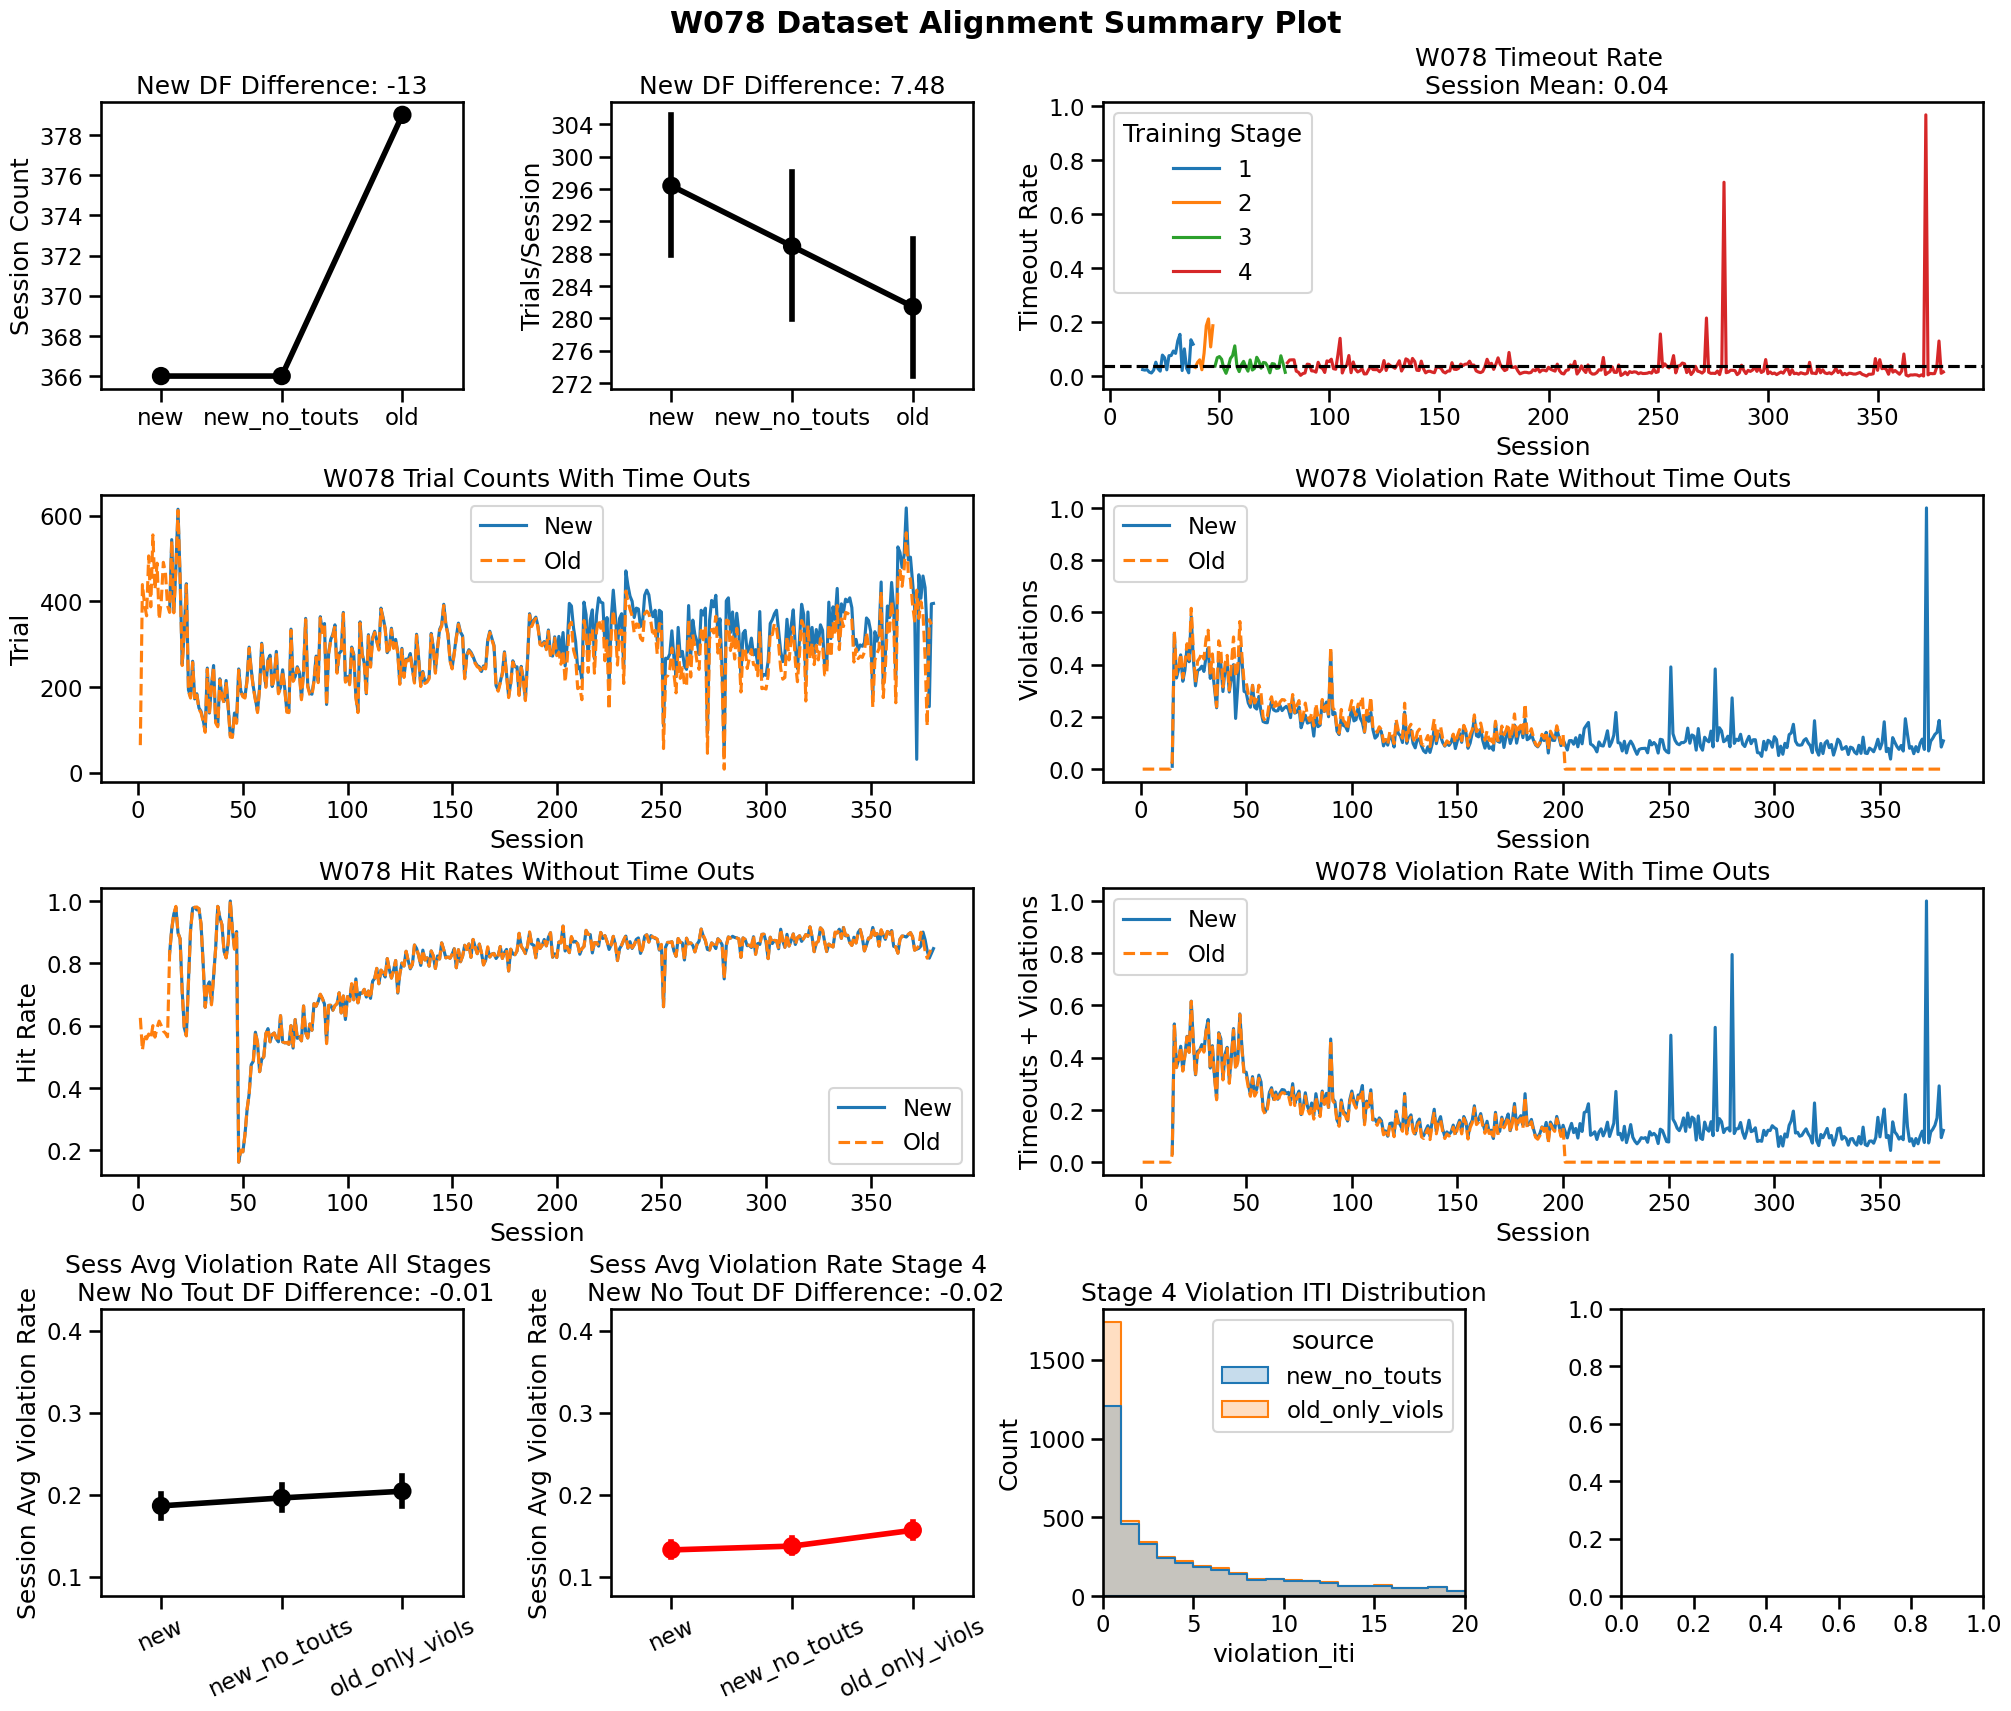

In [560]:
make_mega_alignment_figure(w078)

In [561]:
make_mega_alignment_figure(w078, save_out=True)

figure saved for W078


TODO

clean up!
- put all classes into .py files. align and viz go together under utils, iti gets it's own
- write a wrapper function to iterate over all animals
- test with 2 animals 

in new nb:
- run all of them 
- read in alignment data and merge
- create summary fig of alignment